# Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface  т.к. сеть обучалась на схожем датасете

In [1]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-ms0hb7wf
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-ms0hb7wf
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=bf3b302cc015100d3811fcf22dad958458dddfaf38993bb1d5101dc2c2e09750
  Stored in directory: /tmp/pip-ephem-wheel-cache-hprugrlv/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
! pip install keras_vggface
! pip install keras_applications

     |████████████████████████████████| 51kB 4.1MB/s 


In [4]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
166MB [00:02, 68.5MB/s]


'resnet50face.h5'

In [6]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

In [7]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Проверка верности загрузки

In [8]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2020-09-13 17:14:35--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 104.26.7.169, 104.26.6.169, 172.67.74.175, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|104.26.7.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41762 (41K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  40.78K  --.-KB/s    in 0s      

2020-09-13 17:14:35 (107 MB/s) - ‘brad_pitt.jpg’ saved [41762/41762]



1351680/1346516 [==============================] - 1s 0us/step


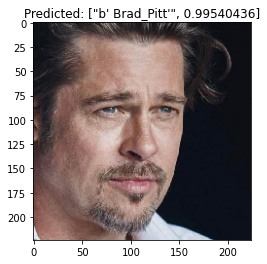

In [9]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)

## Загрузка данных

In [10]:
from pathlib import Path
from collections import Counter

In [11]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:01, 58.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 94.5MB/s]


'train_val_split_utk.csv'

In [12]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))

In [13]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,31_0_4_20170117123923204.jpg.chip.jpg,0.267241,4,0
1,21_1_2_20170104021952837.jpg.chip.jpg,0.181034,2,1
2,16_1_0_20170109212859323.jpg.chip.jpg,0.137931,0,1
3,26_1_3_20170119193120042.jpg.chip.jpg,0.224138,3,1
4,29_0_3_20170119195113147.jpg.chip.jpg,0.250000,3,0


In [14]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [15]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

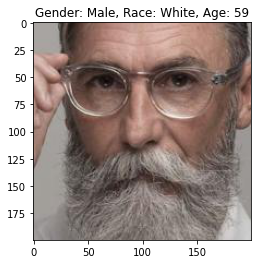

In [19]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


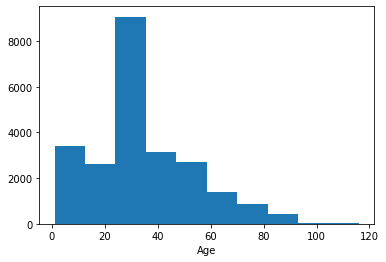

In [20]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

# Формируем модель

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image):
    """
    image -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface 
    """
    
    preprocessed = utils.preprocess_input(image, version=2)

    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col="img_name",
    y_col= 'gender',
    weight_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    classes=None,
    class_mode= "binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True)

val_generator = image_gen.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col="img_name",
    y_col= 'gender',
    weight_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    classes=None,
    class_mode= "binary",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True)

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [23]:
# отрежем от vggface_model последний слой классификатора 
# теперь base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
_______________________________________________________________________________________

In [24]:
!pip install livelossplot
from livelossplot.inputs.tf_keras import PlotLossesCallback

In [25]:
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [26]:
base_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
_______________________________________________________________________________________

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           23628832    input_1[0][0]                    
__________________________________________________________________________________________________
gender (Dense)                  (None, 1)            65          sequential[0][0]                 
__________________________________________________________________________________________________
race (Dense)                    (None, 5)            325         sequential[0][0]                 
_______________________________________________________________________________________

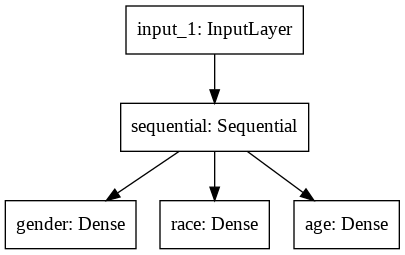

In [27]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model


input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

model_ = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu')
    ])


output_model = model_(input_layer)
output_age = tf.keras.layers.Dense(1, activation='sigmoid', name='age')(output_model)
output_gender = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(output_model)
output_race = tf.keras.layers.Dense(5, activation='softmax', name='race')(output_model)

model = tf.keras.Model(inputs=input_layer, outputs=[output_gender, output_race, output_age])

model.summary()
plot_model(model)

In [28]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="other",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])
    """
    while True:
      data = next(generator)
      image = data[0]
      labels = np.split(data[1].astype("float32"), 3, axis=1)
      labels = [labels[0].reshape((len(labels[0]),)),
          labels[1].reshape((len(labels[1]),)) ,
          labels[2].reshape((len(labels[2]),))]  
      yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 577, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python

# Обучение

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

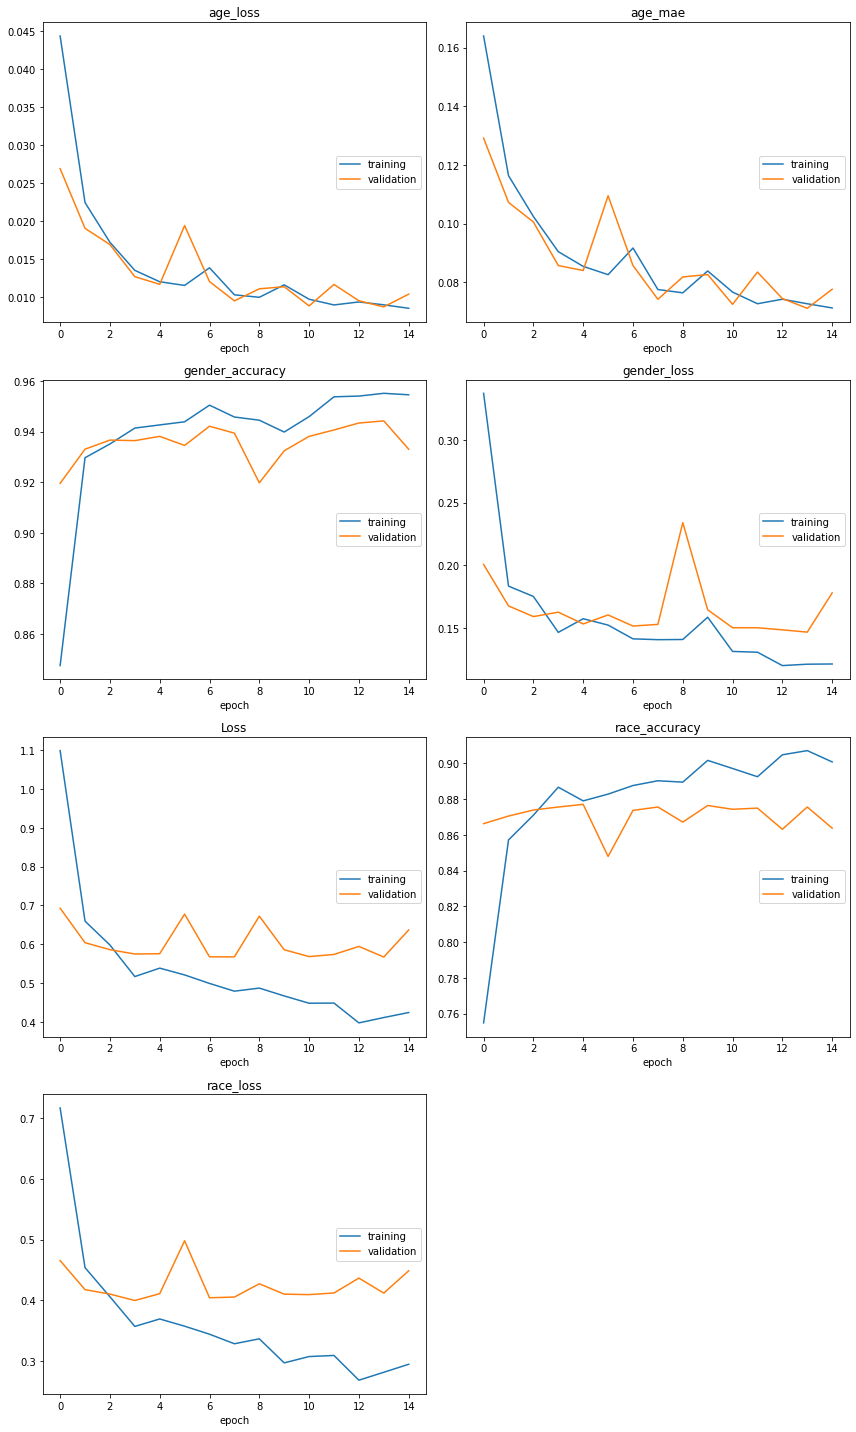

age_loss
	training         	 (min:    0.009, max:    0.044, cur:    0.009)
	validation       	 (min:    0.009, max:    0.027, cur:    0.010)
age_mae
	training         	 (min:    0.071, max:    0.164, cur:    0.071)
	validation       	 (min:    0.071, max:    0.129, cur:    0.078)
gender_accuracy
	training         	 (min:    0.848, max:    0.955, cur:    0.955)
	validation       	 (min:    0.920, max:    0.944, cur:    0.933)
gender_loss
	training         	 (min:    0.120, max:    0.337, cur:    0.121)
	validation       	 (min:    0.146, max:    0.234, cur:    0.178)
Loss
	training         	 (min:    0.398, max:    1.099, cur:    0.424)
	validation       	 (min:    0.567, max:    0.693, cur:    0.637)
race_accuracy
	training         	 (min:    0.755, max:    0.907, cur:    0.901)
	validation       	 (min:    0.848, max:    0.877, cur:    0.864)
race_loss
	training         	 (min:    0.268, max:    0.717, cur:    0.295)
	validation       	 (min:    0.400, max:    0.498, cur:    0.449)
50

In [30]:
model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator), steps_per_epoch=50, validation_steps= len(df_val) // BATCH_SIZE,
                     callbacks=[PlotLossesCallback(), checkpoint])